In [1]:
import torch
from UNet import UNet
from data import SegmentDataset
from torch.nn import Softmax2d, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import tqdm
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
from torchmetrics.classification import JaccardIndex

In [2]:
DATA_IMAGES = "dataset/train/images/"
DATA_MASKS = "dataset/train/masks/"
DATA_TEST_IMAGES = "dataset/test/images/"

IMG_HEIGHT, IMG_WIDTH = 400, 400

BATCH_SZ = 20
EPOCHS = 20

MASK_THRESHOLD = 0.5

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
all_imgs, all_masks = sorted(glob.glob(DATA_IMAGES+"*")), sorted(glob.glob(DATA_MASKS+"*"))
train_data, val_data = train_test_split(np.array([all_imgs,all_masks]).T,test_size=0.2,random_state=88)

In [4]:
trans = transforms.Compose([
 	transforms.Resize((IMG_HEIGHT,IMG_WIDTH)),
	transforms.ToTensor()])

In [6]:
train_dataset = SegmentDataset(train_data[:,0],train_data[:,1],transforms=trans)
val_dataset = SegmentDataset(val_data[:,0],val_data[:,1],transforms=trans)

In [7]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SZ, pin_memory=True)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SZ, pin_memory=True)

In [8]:
unet_model = UNet(2).to(device)
lossFunc = CrossEntropyLoss()
opt = Adam(unet_model.parameters(), lr=0.001)
train_steps = len(train_dataset) // BATCH_SZ
val_steps = len(val_dataset) // BATCH_SZ

In [9]:
stats = {"loss train": [], "loss val": []}
for epoch in tqdm.tqdm(range(EPOCHS)):
	unet_model.train()
	totalTrainLoss = 0
	totalTestLoss = 0
	print("[INFO] Training...")
	for (i, (x, y)) in enumerate(train_dataloader):
		(x, y) = (x.to(device), y.to(device))
		pred = unet_model(x)
		loss = lossFunc(pred, y)

		opt.zero_grad()
		loss.backward()
		opt.step()
		totalTrainLoss += loss
	print("[INFO] Validation...")
	with torch.no_grad():
		unet_model.eval()
		for (x, y) in val_dataloader:
			(x, y) = (x.to(device), y.to(device))
			pred = unet_model(x)
			totalTestLoss += lossFunc(pred, y)

	avgTrainLoss = totalTrainLoss / train_steps
	avgTestLoss = totalTestLoss / val_steps
	stats["loss train"].append(avgTrainLoss.cpu().detach().numpy())
	stats["loss val"].append(avgTestLoss.cpu().detach().numpy())
	print("[INFO] EPOCH: {}/{}".format(epoch + 1, EPOCHS))
	print("Train loss: {:.6f}, Validation loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
	if epoch > 0 and (epoch+1) % 5 == 0:
		torch.save(unet_model,f"saves/weights_{epoch+1}_epoch.pt")

  0%|          | 0/20 [00:00<?, ?it/s]

[INFO] Training...
[INFO] Validation...


  5%|▌         | 1/20 [06:41<2:07:12, 401.71s/it]

[INFO] EPOCH: 1/20
Train loss: 0.712002, Validation loss: 0.5277
[INFO] Training...
[INFO] Validation...


 10%|█         | 2/20 [09:29<1:19:15, 264.18s/it]

[INFO] EPOCH: 2/20
Train loss: 0.316025, Validation loss: 0.3438
[INFO] Training...
[INFO] Validation...


 15%|█▌        | 3/20 [12:17<1:02:23, 220.19s/it]

[INFO] EPOCH: 3/20
Train loss: 0.270138, Validation loss: 0.2563
[INFO] Training...
[INFO] Validation...


 20%|██        | 4/20 [15:06<53:17, 199.84s/it]  

[INFO] EPOCH: 4/20
Train loss: 0.213988, Validation loss: 0.1761
[INFO] Training...
[INFO] Validation...


 25%|██▌       | 5/20 [17:51<46:53, 187.53s/it]

[INFO] EPOCH: 5/20
Train loss: 0.169354, Validation loss: 0.1545
[INFO] Training...
[INFO] Validation...


 30%|███       | 6/20 [20:37<41:59, 179.96s/it]

[INFO] EPOCH: 6/20
Train loss: 0.147105, Validation loss: 0.1365
[INFO] Training...
[INFO] Validation...


 35%|███▌      | 7/20 [23:21<37:53, 174.90s/it]

[INFO] EPOCH: 7/20
Train loss: 0.132679, Validation loss: 0.1263
[INFO] Training...
[INFO] Validation...


 40%|████      | 8/20 [26:06<34:22, 171.88s/it]

[INFO] EPOCH: 8/20
Train loss: 0.118633, Validation loss: 0.1155
[INFO] Training...
[INFO] Validation...


 45%|████▌     | 9/20 [28:51<31:06, 169.72s/it]

[INFO] EPOCH: 9/20
Train loss: 0.110907, Validation loss: 0.1124
[INFO] Training...
[INFO] Validation...


 50%|█████     | 10/20 [31:37<28:04, 168.46s/it]

[INFO] EPOCH: 10/20
Train loss: 0.101230, Validation loss: 0.1002
[INFO] Training...
[INFO] Validation...


 55%|█████▌    | 11/20 [34:23<25:08, 167.56s/it]

[INFO] EPOCH: 11/20
Train loss: 0.095678, Validation loss: 0.0998
[INFO] Training...
[INFO] Validation...


 60%|██████    | 12/20 [37:07<22:11, 166.48s/it]

[INFO] EPOCH: 12/20
Train loss: 0.089134, Validation loss: 0.1056
[INFO] Training...
[INFO] Validation...


 65%|██████▌   | 13/20 [39:52<19:23, 166.24s/it]

[INFO] EPOCH: 13/20
Train loss: 0.084700, Validation loss: 0.0863
[INFO] Training...
[INFO] Validation...


 70%|███████   | 14/20 [42:41<16:42, 167.10s/it]

[INFO] EPOCH: 14/20
Train loss: 0.081367, Validation loss: 0.0893
[INFO] Training...
[INFO] Validation...


 75%|███████▌  | 15/20 [45:31<13:58, 167.73s/it]

[INFO] EPOCH: 15/20
Train loss: 0.073621, Validation loss: 0.0788
[INFO] Training...
[INFO] Validation...


 80%|████████  | 16/20 [48:18<11:10, 167.71s/it]

[INFO] EPOCH: 16/20
Train loss: 0.069056, Validation loss: 0.0776
[INFO] Training...
[INFO] Validation...


 85%|████████▌ | 17/20 [50:55<08:13, 164.50s/it]

[INFO] EPOCH: 17/20
Train loss: 0.064648, Validation loss: 0.0813
[INFO] Training...
[INFO] Validation...


 90%|█████████ | 18/20 [53:32<05:24, 162.18s/it]

[INFO] EPOCH: 18/20
Train loss: 0.064675, Validation loss: 0.0756
[INFO] Training...
[INFO] Validation...


 95%|█████████▌| 19/20 [56:08<02:40, 160.40s/it]

[INFO] EPOCH: 19/20
Train loss: 0.060774, Validation loss: 0.0706
[INFO] Training...
[INFO] Validation...


100%|██████████| 20/20 [58:44<00:00, 176.23s/it]

[INFO] EPOCH: 20/20
Train loss: 0.054569, Validation loss: 0.0780


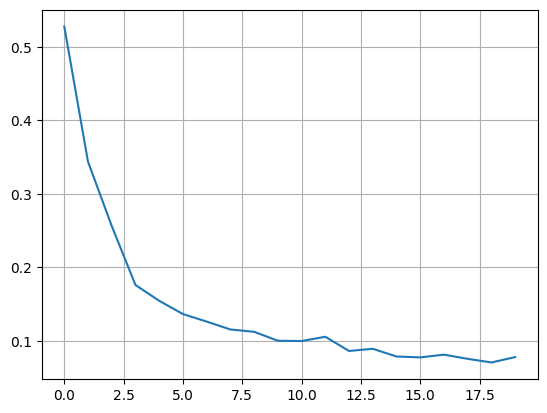

In [10]:
plt.plot(range(EPOCHS),stats["loss train"],label="Train loss")
plt.plot(range(EPOCHS),stats["loss val"],label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Cross-entropy loss")
plt.xticks(list(range(1,EPOCHS+1)))
plt.grid(True)
plt.legend()

In [11]:
unet_model.eval()

UNet(
  (poolling_list): ModuleList(
    (0-3): 4 x MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stack_1): StackDown(
    (layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
    )
  )
  (stack_2): StackDown(
    (layers): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
    )
  )
  (stack_3): StackDown(
    (layers): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
    )
  )
  (stack_4): StackDown(
    (layers): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU

In [5]:
unet = torch.load("saves/weights_20_epochs.pt").to(device)

In [7]:
all_test_imgs, all_test_masks = sorted(glob.glob(DATA_TEST_IMAGES+"*")), None
test_dataset = SegmentDataset(all_test_imgs,all_test_masks,transforms=trans)

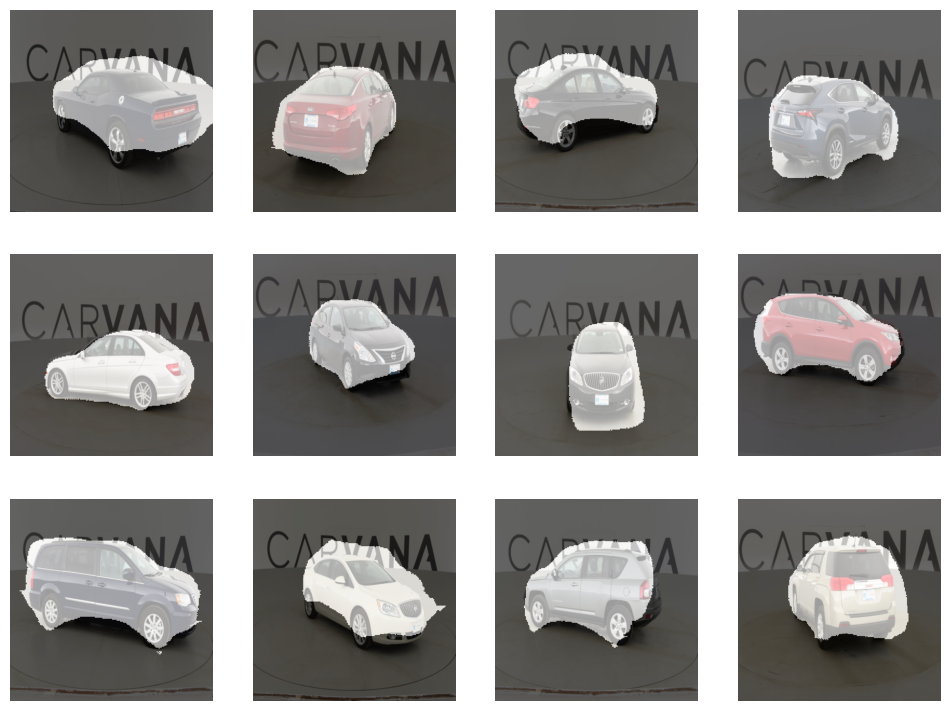

In [38]:
plt.rcParams["figure.figsize"] = (12,9)
fig, ax =plt.subplots(3,4)

for i_ in range(3):
	for j_ in range(4):
		img, mask = test_dataset.__getitem__(random.randint(0,len(test_dataset)))
		pred =unet(img.reshape(1,3,IMG_HEIGHT,IMG_WIDTH).to(device)).detach().cpu()
		pred_ =  Softmax2d()(pred).numpy().reshape((2,IMG_HEIGHT,IMG_WIDTH))[1] > MASK_THRESHOLD

		
		ax[i_,j_].axis("off")
		ax[i_,j_].imshow(img.permute((1,2,0)).numpy())
		ax[i_,j_].imshow(pred_,cmap="gray",alpha=0.6)